In [1]:
import os
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import seaborn as sns
import modules_TFM as mod

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

The library modules_TFM is my own library where I have dropped some functions that i have used 

In [2]:
import time
print(' Last revision ', time.asctime())
frames = []

for ifile in range(0, 8000): # Bucle para leer cada archivo individualmente 
    
    file = f'/Users/pablo/OneDrive - Universidade de Santiago de Compostela/Máster/TFM/dorothea/dorothea_{ifile}_kr83m.h5'

    if os.path.exists(file): # En caso de que el path del archivo exista, lo abre como DataFrame 
        
        if ifile%2==0: 
            
            #print(file)
            
            dst = pd.DataFrame(tb.open_file(file).root.DST.Events[:]) 

            frames.append(dst) # Guarda cada uno de los DataFrames en una lista
            
kdst = pd.concat(frames, ignore_index=True) # Hace un nuevo DataFrame juntando los individuales

kdst

 Last revision  Thu Nov 21 16:16:37 2024


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1600,1.601953e+09,0,0,1,1,200.0,7.0,19.0,10000.0,...,9,669.487854,562.369751,3.578721,-459.760008,-55.820768,463.136290,-3.020771,11.071444,10.575179
1,1602,1.602744e+09,0,0,1,1,125.0,5.0,15.0,10000.0,...,7,548.483154,460.725830,3.178156,-453.294198,-161.574950,481.229773,-2.799187,9.536605,10.081681
2,1604,1.605633e+09,0,0,1,1,250.0,3.0,14.0,10000.0,...,8,151.499710,127.259750,1.900903,443.049486,-14.897329,443.299873,-0.033612,9.465026,10.122552
3,1606,1.607813e+09,0,0,1,1,175.0,6.0,17.0,10000.0,...,8,516.493958,433.854889,3.219601,409.438144,-247.895722,478.635439,-0.544420,10.356321,10.591151
4,1608,1.608176e+09,0,0,1,1,175.0,4.0,15.0,10000.0,...,8,363.481140,305.324158,2.673991,-36.718107,-461.022901,462.482794,-1.650273,9.796269,10.497626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490087,6399190,6.399191e+12,0,0,1,1,250.0,5.0,21.0,10050.0,...,9,962.429321,808.440552,4.166302,-22.263757,224.603664,225.704410,1.669598,11.410413,11.547462
1490088,6399192,6.399192e+12,0,0,1,1,200.0,8.0,22.0,10000.0,...,9,1404.501953,1179.781616,4.982812,240.522545,-164.642069,291.475738,-0.600260,11.732220,10.877596
1490089,6399194,6.399195e+12,0,0,1,1,200.0,4.0,12.0,10050.0,...,7,435.438019,365.767914,2.907131,206.605181,-53.940802,213.530585,-0.255381,9.354601,10.132411
1490090,6399196,6.399196e+12,0,0,1,1,125.0,3.0,9.0,10000.0,...,6,315.484100,265.006622,2.488038,65.532921,-44.267010,79.083069,-0.594088,8.805151,8.863330


### Binned energy in XY planes

In [3]:
energías_eventos_corte=[]
DT_corte=[]
X_corte=[]
Y_corte=[]


for i in range(len(kdst['S2e'])):
    if 715>kdst['DT'][i] and 685<kdst['DT'][i]:
        energías_eventos_corte.append(kdst['S2e'][i])
        X_corte.append(kdst['X'][i])
        Y_corte.append(kdst['Y'][i])
        DT_corte.append(kdst['DT'][i])
        
print(f'El porcentaje de eventos dentro de este corte es {np.round(len(energías_eventos_corte)/len(kdst['S2e'])*100,3)}%')

El porcentaje de eventos dentro de este corte es 2.182%


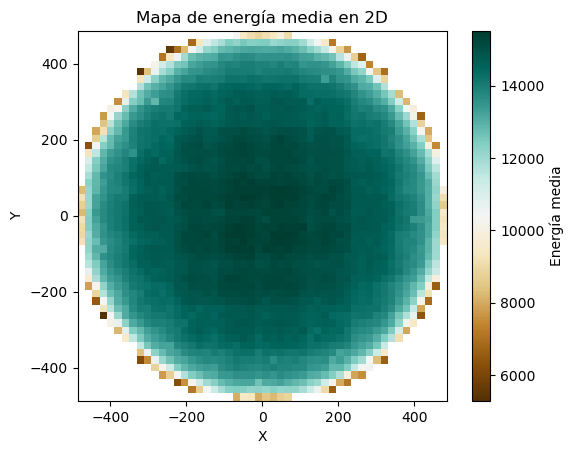

In [4]:
mean_E, x_edges,y_edges,binned = binned_statistic_2d(X_corte, Y_corte, energías_eventos_corte, statistic='mean', bins=50)
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  
c = ax.pcolormesh(X, Y, mean_E.T, cmap='BrBG')
plt.colorbar(c, label='Energía media')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mapa de energía media en 2D')
ax.set_aspect('equal')  

plt.show()

### Interpolation of values

We can use functions of our module, so we can get the value of DT for an arbitrary S2w, for example. Let's see this

In [5]:
def interp_value(x_data, y_data, point):
    x,y=mod.profiles(x_data, y_data)
    mod.interpolation(x,y,point,kind='linear')

In [6]:
import random as rd
print('Lets do some predicts')

for i in range(2):
    random_test=rd.gauss(mu=25,sigma=7)
    interp_value(kdst['DT'], kdst['S2w'], point=random_test)


Lets do some predicts
False
Interpolated value at y=27.717983267877777 using interpolation: 814.636969910339
False
Interpolated value at y=43.03991620575725 using interpolation: 2342.5693928791334


### Geometric efficiency

We are doing geometric studies to try to determine the theoretical efficiency of our detector. Let's start by calculating the solid angle. 

$\hspace{10cm}\Omega=\int^{2\pi}_{0}\int^{\pi}_{0}d\varphi d(cos\theta)=2\pi(1-cos\theta)$

Let´s consider now a detector of radius $R=1$ and a desintegration centered in the $XY$ plane but at a distance $d=10 \hspace{.1cm}$  so  $\hspace{.1cm} tan\theta=0.1 \Rightarrow \theta \approx 5.71º$. The geometric efficiency will be the rate between the solid angle at $d=0 \rightarrow \theta = 90º$ and the solid angle at $\theta=5.71º$. Calculating this rate we get a ratio of $\epsilon_g=0.00496$.

Let's see what happens if we calculate the efficiency via a Montecarlo simulation. I have implemented this function in my own module so I'll just import it:


In [7]:
simulation=mod.MonteCarlo(1,10,10000,[0,0,0])
print(f'The efficiency with a Montecarlo simulation for particles at d=10 is {simulation[0]} +-{simulation[1]}')

The efficiency with a Montecarlo simulation for particles at d=10 is 0.0048 +-0.0006911555541265656


### Ratio of energy lost with DT

We are going to calculate the percentage of energy that is lost in each bin of the XY plane of the detector.To do this, first we are going to divide the coordinates $X$ and $Y$ into two subsets, one for DT lower that 200 and other for larger DT, this is more than 1200, and we create 2 other arrays with the energy of the S2 signal for this two zones of the cilinder

In [8]:
High_X = np.array([d for s, d in zip(kdst['DT'], kdst['X']) if s > 10 and s<200])
High_Y = np.array([d for s, d in zip(kdst['DT'], kdst['Y']) if s > 10 and s<200])
High_S2e = np.array([d for s, d in zip(kdst['DT'], kdst['S2e']) if s > 10 and s<200])

Low_X = np.array([d for s, d in zip(kdst['DT'], kdst['X']) if s>1200])
Low_Y = np.array([d for s, d in zip(kdst['DT'], kdst['Y']) if s>1200])
Low_S2e = np.array([d for s, d in zip(kdst['DT'], kdst['S2e']) if s>1200])

Then we calculate the mean energy that arrives to each bin and we plot the histogram.

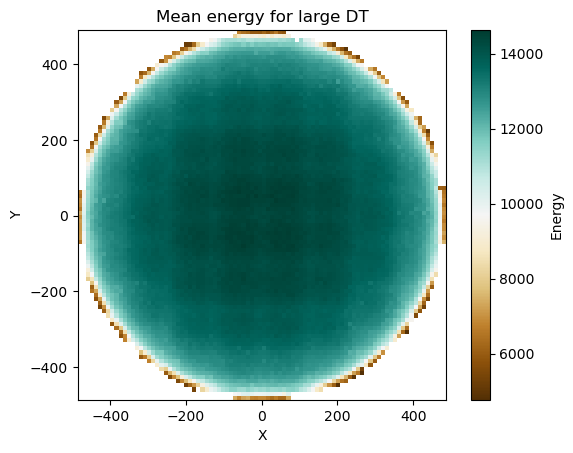

In [9]:
mean_E_Low, x_edges,y_edges,binned = binned_statistic_2d(Low_X, Low_Y, Low_S2e, statistic='mean', bins=90)
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  
c = ax.pcolormesh(X, Y, mean_E_Low.T, cmap='BrBG')
plt.colorbar(c, label='Energy')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean energy for large DT')
ax.set_aspect('equal')  

plt.show()

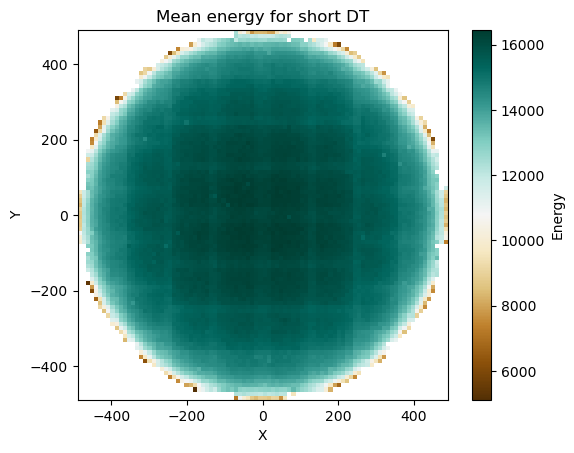

In [10]:
mean_E_high, x_edges,y_edges,binned = binned_statistic_2d(High_X, High_Y, High_S2e, statistic='mean', bins=90)
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  
c = ax.pcolormesh(X, Y, mean_E_high.T, cmap='BrBG')
plt.colorbar(c, label='Energy')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean energy for short DT')
ax.set_aspect('equal')  

plt.show()


Even though the shape we see is the same for both plots, it is obvious that the scale in the colorbar is way bigger shor small DT as in that case we have energies up to 16000 pes while for long distances we just reach energies of 14000 pes. To compute the radio of energy lost we calculate the ratio of both histograms

In [11]:
ratio=mean_E_Low/mean_E_high

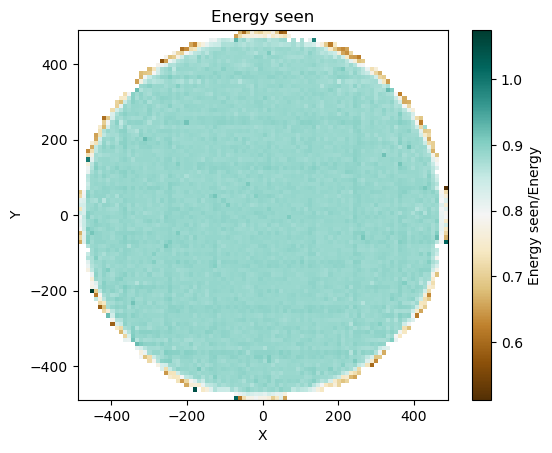

In [12]:
X, Y = np.meshgrid(x_edges, y_edges)

fig, ax = plt.subplots()  
c = ax.pcolormesh(X, Y, ratio.T, cmap='BrBG')
plt.colorbar(c, label='Energy seen/Energy')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Energy seen')
ax.set_aspect('equal')  

plt.show()

We see that the energy correction we need is almost constant in the detector and is about an .85